# Data Mining Projekt
## Wie soll der nächste Charakter aussehen?
___

## Problemdefiniton
In League of Legends beeinflussen neue Champions die Spielbalance. Doch sind bestimmte Champion-Typen unterrepräsentiert? Diese Arbeit nutzt Machine Learning, um vorherzusagen, welche Champion-Eigenschaften im aktuellen Spielgewicht fehlen.

So wird sich die zentrale Frage gestellt: Welche Klassen-Rollen-Kombination ist bei sonst durchschnittlichen Werten im derzeitigen Spielökosystem am stärksten unterrepräsentiert und könnte als Grundlage für die Entwicklung eines neuen Champions dienen?

## Import - Datenauswahl

### Import notwendiger Bibliotheken


In [ ]:
# Datenverarbeitung & Numerik
import pandas as pd  
import numpy as np  

# Visualisierung
import matplotlib.pyplot as plt  
import seaborn as sns  
%matplotlib inline  

# Datenaufbereitung & Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder  
from sklearn.model_selection import train_test_split  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Modelle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  
from sklearn.linear_model import LogisticRegression, LinearRegression  
from sklearn.svm import SVC  
from sklearn.neural_network import MLPRegressor  
from xgboost import XGBClassifier, XGBRegressor 
from xgboost import plot_importance


# Modellbewertung
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Hyperparameter-Tuning
from sklearn.model_selection import GridSearchCV

# Explorative Datenanalyse
from ydata_profiling import ProfileReport  

# Sonstiges
import itertools  
from itertools import product
import pickle  

### Datenimport

Der folgende Datensatz wurde auf der Website "Kaggle" gefunden, hat seinen Ursprung jedoch in
der Analyse- und Datenplattform MetaSRC. Diese Plattform sammelt, aggregiert und analysiert Match-Daten
um die Trends des Spiels League of Legends darzustellen.
Die Daten werden direkt aus öffentlichen Riot Games-APIs bezogen, wodurch die Statistiken
patch-basiert aktualisiert werden.

In [2]:
# Datensatz laden
df = pd.read_csv('../Daten/League of Legends Champion Stats 12.1.csv', sep=';')
df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23


Der nächste Datensatz entstammt auch Kaggle, hat aber seinen Ursprung in dem "League of Legends Wiki Champion Data Module".
Da dieser Veröffentlichungsdaten beinhaltet, eignet sich dieser für Zeitreihenanalysen
Der Fokus liegt allerdings auf ersterem Datensatz, dieser dient nur als Hilfe für die Zeitreihenanalyse


In [3]:
df_basic = pd.read_csv('../Daten/200125_LoL_champion_data.csv')
df_basic.head()

,Unnamed: 0,id,apiname,title,difficulty,herotype,alttype,resource,stats,rangetype,...,be,rp,skill_i,skill_q,skill_w,skill_e,skill_r,skills,fullname,nickname
0,Aatrox,266.0,Aatrox,the Darkin Blade,2,Fighter,Tank,Blood Well,"{'hp_base': 650, 'hp_lvl': 114, 'mp_base': 0, ...",Melee,...,4800,880,{1: 'Deathbringer Stance'},"{1: 'The Darkin Blade', 2: 'The Darkin Blade 3'}",{1: 'Infernal Chains'},{1: 'Umbral Dash'},{1: 'World Ender'},"{1: 'Deathbringer Stance', 2: 'The Darkin Blad...",NaN,NaN
1,Ahri,103.0,Ahri,the Nine-Tailed Fox,2,Mage,Assassin,Mana,"{'hp_base': 590, 'hp_lvl': 104, 'mp_base': 418...",Ranged,...,3150,790,{1: 'Essence Theft'},{1: 'Orb of Deception'},{1: 'Fox-Fire'},{1: 'Charm'},{1: 'Spirit Rush'},"{1: 'Essence Theft', 2: 'Orb of Deception', 3:...",NaN,NaN
2,Akali,84.0,Akali,the Rogue Assassin,2,Assassin,NaN,Energy,"{'hp_base': 600, 'hp_lvl': 119, 'mp_base': 200...",Melee,...,3150,790,"{1: ""Assassin's Mark""}",{1: 'Five Point Strike'},{1: 'Twilight Shroud'},{1: 'Shuriken Flip'},{1: 'Perfect Execution'},"{1: ""Assassin's Mark"", 2: 'Five Point Strike',...",Akali Jhomen Tethi,NaN
3,Akshan,166.0,Akshan,the Rogue Sentinel,3,Marksman,Assassin,Mana,"{'hp_base': 630, 'hp_lvl': 107, 'mp_base': 350...",Ranged,...,4800,880,{1: 'Dirty Fighting'},{1: 'Avengerang'},{1: 'Going Rogue'},{1: 'Heroic Swing'},{1: 'Comeuppance'},"{1: 'Dirty Fighting', 2: 'Avengerang', 3: 'Goi...",NaN,NaN
4,Alistar,12.0,Alistar,the Minotaur,1,Tank,Support,Mana,"{'hp_base': 685, 'hp_lvl': 120, 'mp_base': 350...",Melee,...,1350,585,{1: 'Triumphant Roar'},{1: 'Pulverize'},{1: 'Headbutt'},{1: 'Trample'},{1: 'Unbreakable Will'},"{1: 'Triumphant Roar', 2: 'Pulverize', 3: 'Hea...",NaN,NaN


### Merging

In [4]:
# Verbunden werden die Datensätze durch den gemeinsamen Schlüssel des Champion-Namens
# Dabei wollen wir zum ersten Datensatz die Informationen bezüglich Veröffenlichungsdatum hinzufügen

# Spaltennamen für Konsistenz anpassen
df_basic.rename(columns={'apiname': 'Name'}, inplace=True)

# 'date' Spalte in datetime umwandeln
df_basic['date'] = pd.to_datetime(df_basic['date'], errors='coerce')

# Füge die Veröffentlichungsdaten aus df_basic zum Haupt-Datensatz df hinzu
df = pd.merge(df, df_basic[['Name', 'date']], on='Name', how='left')

df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,date
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97,2013-06-13
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56,2011-12-14
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34,2010-05-11
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04,2010-05-11
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23,2021-07-22


## EDA und Preprocessing

Da dies ein Machine Learning Projekt ist, ist es wichtig, dass wir in den folgenden Abschnitten einen Überblick über die Daten erhalten und die Daten entsprechend vorbereiten.
Für die spätere Modellerstellung ist es dabei wichtig, dass Nullwerte entfernt werden, die Daten in numerische Werte umgewandelt werden und die Daten in Trainings- und Testdaten aufgeteilt werden.
Auch Skalierung der Daten ist wichtig, um sicherzustellen, dass die Modelle korrekt trainiert werden.
Der erste Schritt ist es, sich die Daten genauer anzuschauen, um zu sehen, welche Daten vorhanden sind und wie sie aussehen.

In [5]:
df.shape

(234, 12)

In [6]:
# Übersicht über die Daten
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Name    234 non-null    object        
 1   Class   233 non-null    object        
 2   Role    234 non-null    object        
 3   Tier    234 non-null    object        
 4   Score   234 non-null    float64       
 5   Trend   234 non-null    float64       
 6   Win %   234 non-null    object        
 7   Role %  234 non-null    object        
 8   Pick %  234 non-null    object        
 9   Ban %   234 non-null    object        
 10  KDA     234 non-null    float64       
 11  date    214 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 22.1+ KB


In [7]:
# Beschreibung der numerischen Spalten
print(df.describe())

            Score       Trend         KDA                           date
count  234.000000  234.000000  234.000000                            214
mean    49.953675   -0.282991    2.332863  2012-08-29 08:17:56.635514112
min     11.030000  -20.170000    1.450000            2009-02-21 00:00:00
25%     38.935000   -3.480000    2.040000            2009-10-10 00:00:00
50%     46.560000   -0.815000    2.305000            2011-05-10 00:00:00
75%     59.100000    2.060000    2.547500            2013-12-13 00:00:00
max     94.230000   44.710000    4.110000            2021-09-23 00:00:00
std     16.473484    6.418863    0.414238                            NaN


### Zeitreihenanalyse

In [8]:
# Veröffentlichungsdatum extrahieren
df['release_year'] = df['date'].dt.year

# Date spalte entfernen
df.drop('date', axis=1, inplace=True)

In [9]:
# Anzahl der veröffentlichten Champions pro Jahr berechnen
release_counts = df['release_year'].value_counts().sort_index()

In [10]:
# Veröffentlichung pro Rolle und Klasse
role_counts = df.groupby(['release_year', 'Role']).size().unstack()
class_counts = df.groupby(['release_year', 'Class']).size().unstack()

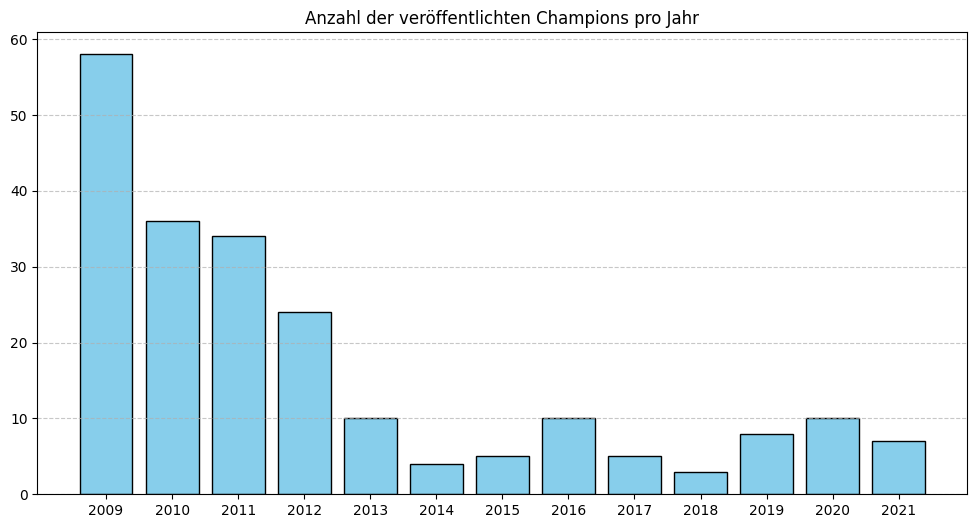

In [11]:
# Anzahl veröffentlichter Champions pro Jahr 
plt.figure(figsize=(12, 6))
plt.bar(release_counts.index, release_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("")
plt.ylabel("")
plt.title("Anzahl der veröffentlichten Champions pro Jahr")
plt.xticks(release_counts.index) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preprocessing: In numerische Werte umwandeln

In [12]:
# Umwandlung von Prozentangaben in numerische Werte
df["Win %"] = df["Win %"].str.replace('%', '').astype(float)
df["Role %"] = df["Role %"].str.replace('%', '').astype(float)
df["Pick %"] = df["Pick %"].str.replace('%', '').astype(float)
df["Ban %"] = df["Ban %"].str.replace('%', '').astype(float)


print(df["Pick %"].describe())


count    234.000000
mean       4.163077
std        4.089208
min        0.180000
25%        1.212500
50%        2.970000
75%        5.790000
max       24.550000
Name: Pick %, dtype: float64


### Betrachtung fehlender Werte

In [13]:
# Fehlende Werte
print(df.isnull().sum())

Name             0
Class            1
Role             0
Tier             0
Score            0
Trend            0
Win %            0
Role %           0
Pick %           0
Ban %            0
KDA              0
release_year    20
dtype: int64


In [14]:
# Alle Zeilen ausgeben, in denen das 'release_year' fehlt
missing_year_rows = df[df["release_year"].isnull()]
print(missing_year_rows)


             Name     Class     Role Tier  Score  Trend  Win %  Role %  \
14   Aurelion Sol      Mage      MID    B  42.15  -2.74  50.81   91.23   
25       Cho'Gath      Tank      TOP    A  52.76   2.64  52.82   72.56   
26       Cho'Gath      Tank      MID    C  37.75  -4.65  49.57   17.42   
31      Dr. Mundo  Marksman      TOP    S  62.73  -2.08  51.76   91.81   
64      Jarvan IV      Tank   JUNGLE    A  54.92   4.21  51.04   93.41   
71         Kai'Sa  Marksman      ADC  God  75.52  10.50  49.48   97.77   
84        Kha'Zix  Assassin   JUNGLE    S  60.25  -2.33  50.17   98.88   
90        Kog'Maw  Marksman      ADC    B  39.80  -2.80  52.79   89.17   
91        LeBlanc  Assassin      MID    A  59.14  -1.18  48.85   94.88   
92        Lee Sin   Fighter   JUNGLE  God  91.89   0.28  48.45   96.61   
107     Master Yi  Assassin   JUNGLE    S  64.59  -3.49  49.74   93.04   
108  Miss Fortune  Marksman      ADC    A  50.67  -1.80  50.10   95.35   
134       Rek'Sai   Fighter   JUNGLE  

In [15]:
mean_year = round(df["release_year"].mean())  # Aufrunden, da Jahre ganzzahlig sind
df["release_year"].fillna(mean_year, inplace=True)


C:\Users\maxtr\AppData\Local\Temp\ipykernel_22144\1149324012.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["release_year"].fillna(mean_year, inplace=True)


In [16]:
print(df.isnull().sum())

Name            0
Class           1
Role            0
Tier            0
Score           0
Trend           0
Win %           0
Role %          0
Pick %          0
Ban %           0
KDA             0
release_year    0
dtype: int64


In [17]:
# Die Zeile ausgeben, in welcher ein Wert für 'Class' fehlt
missing_names_rows = df[df["Class"].isnull()]  
print(missing_names_rows)

      Name Class Role Tier  Score  Trend  Win %  Role %  Pick %  Ban %   KDA  \
95  Lillia   NaN  TOP    D  24.34  -9.25   49.2   11.49     0.4   1.01  1.96   

    release_year  
95        2020.0  


In [18]:
# Den Champion 'Lillia' anzeigen
df[df['Name'] == 'Lillia']

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
94,Lillia,Fighter,JUNGLE,B,42.51,-1.69,49.35,85.39,2.74,0.95,2.66,2020.0
95,Lillia,NaN,TOP,D,24.34,-9.25,49.20,11.49,0.40,1.01,1.96,2020.0


In [19]:
# Da ich weiss, dass Lillia Fighter ist, kann ich den Wert direkt einfügen
df.loc[df['Name'] == 'Lillia', 'Class'] = 'Fighter'

In [20]:
print(df.isnull().sum())

Name            0
Class           0
Role            0
Tier            0
Score           0
Trend           0
Win %           0
Role %          0
Pick %          0
Ban %           0
KDA             0
release_year    0
dtype: int64


### Weitere EDA-Visualisierungen

<Figure size 1200x600 with 0 Axes>

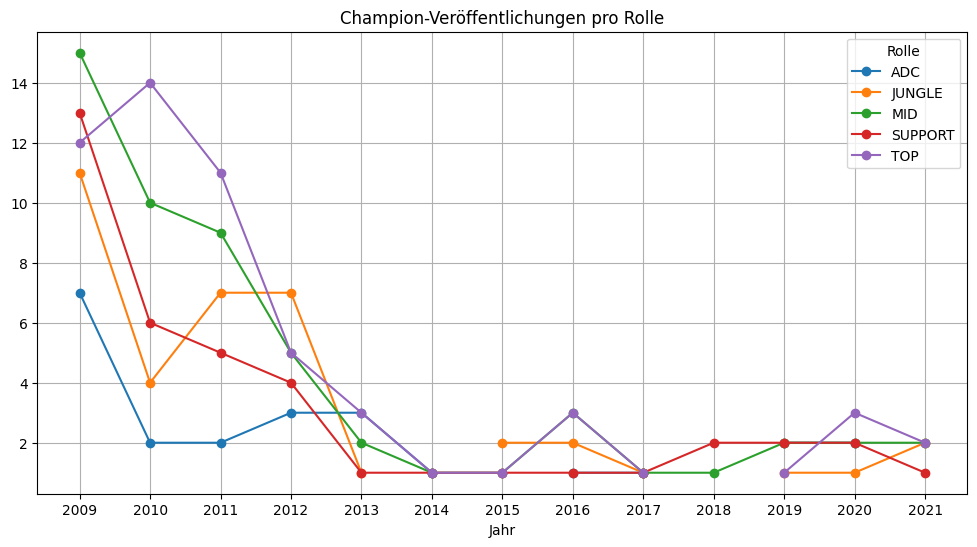

In [21]:
# Veröffentlichungen nach Rolle
plt.figure(figsize=(12, 6))
role_counts.plot(kind='line', marker='o', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("")
plt.title("Champion-Veröffentlichungen pro Rolle")
plt.xticks(release_counts.index)
plt.legend(title="Rolle")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

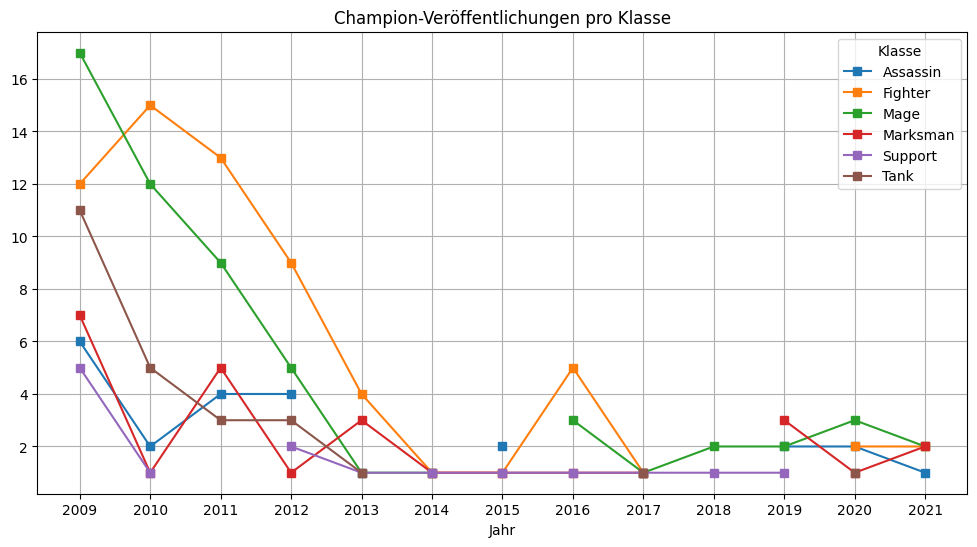

In [22]:
# Veröffentlichungen nach Klasse
plt.figure(figsize=(12, 6))
class_counts.plot(kind='line', marker='s', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("")
plt.title("Champion-Veröffentlichungen pro Klasse")
plt.xticks(release_counts.index)
plt.legend(title="Klasse")
plt.grid(True)
plt.show()

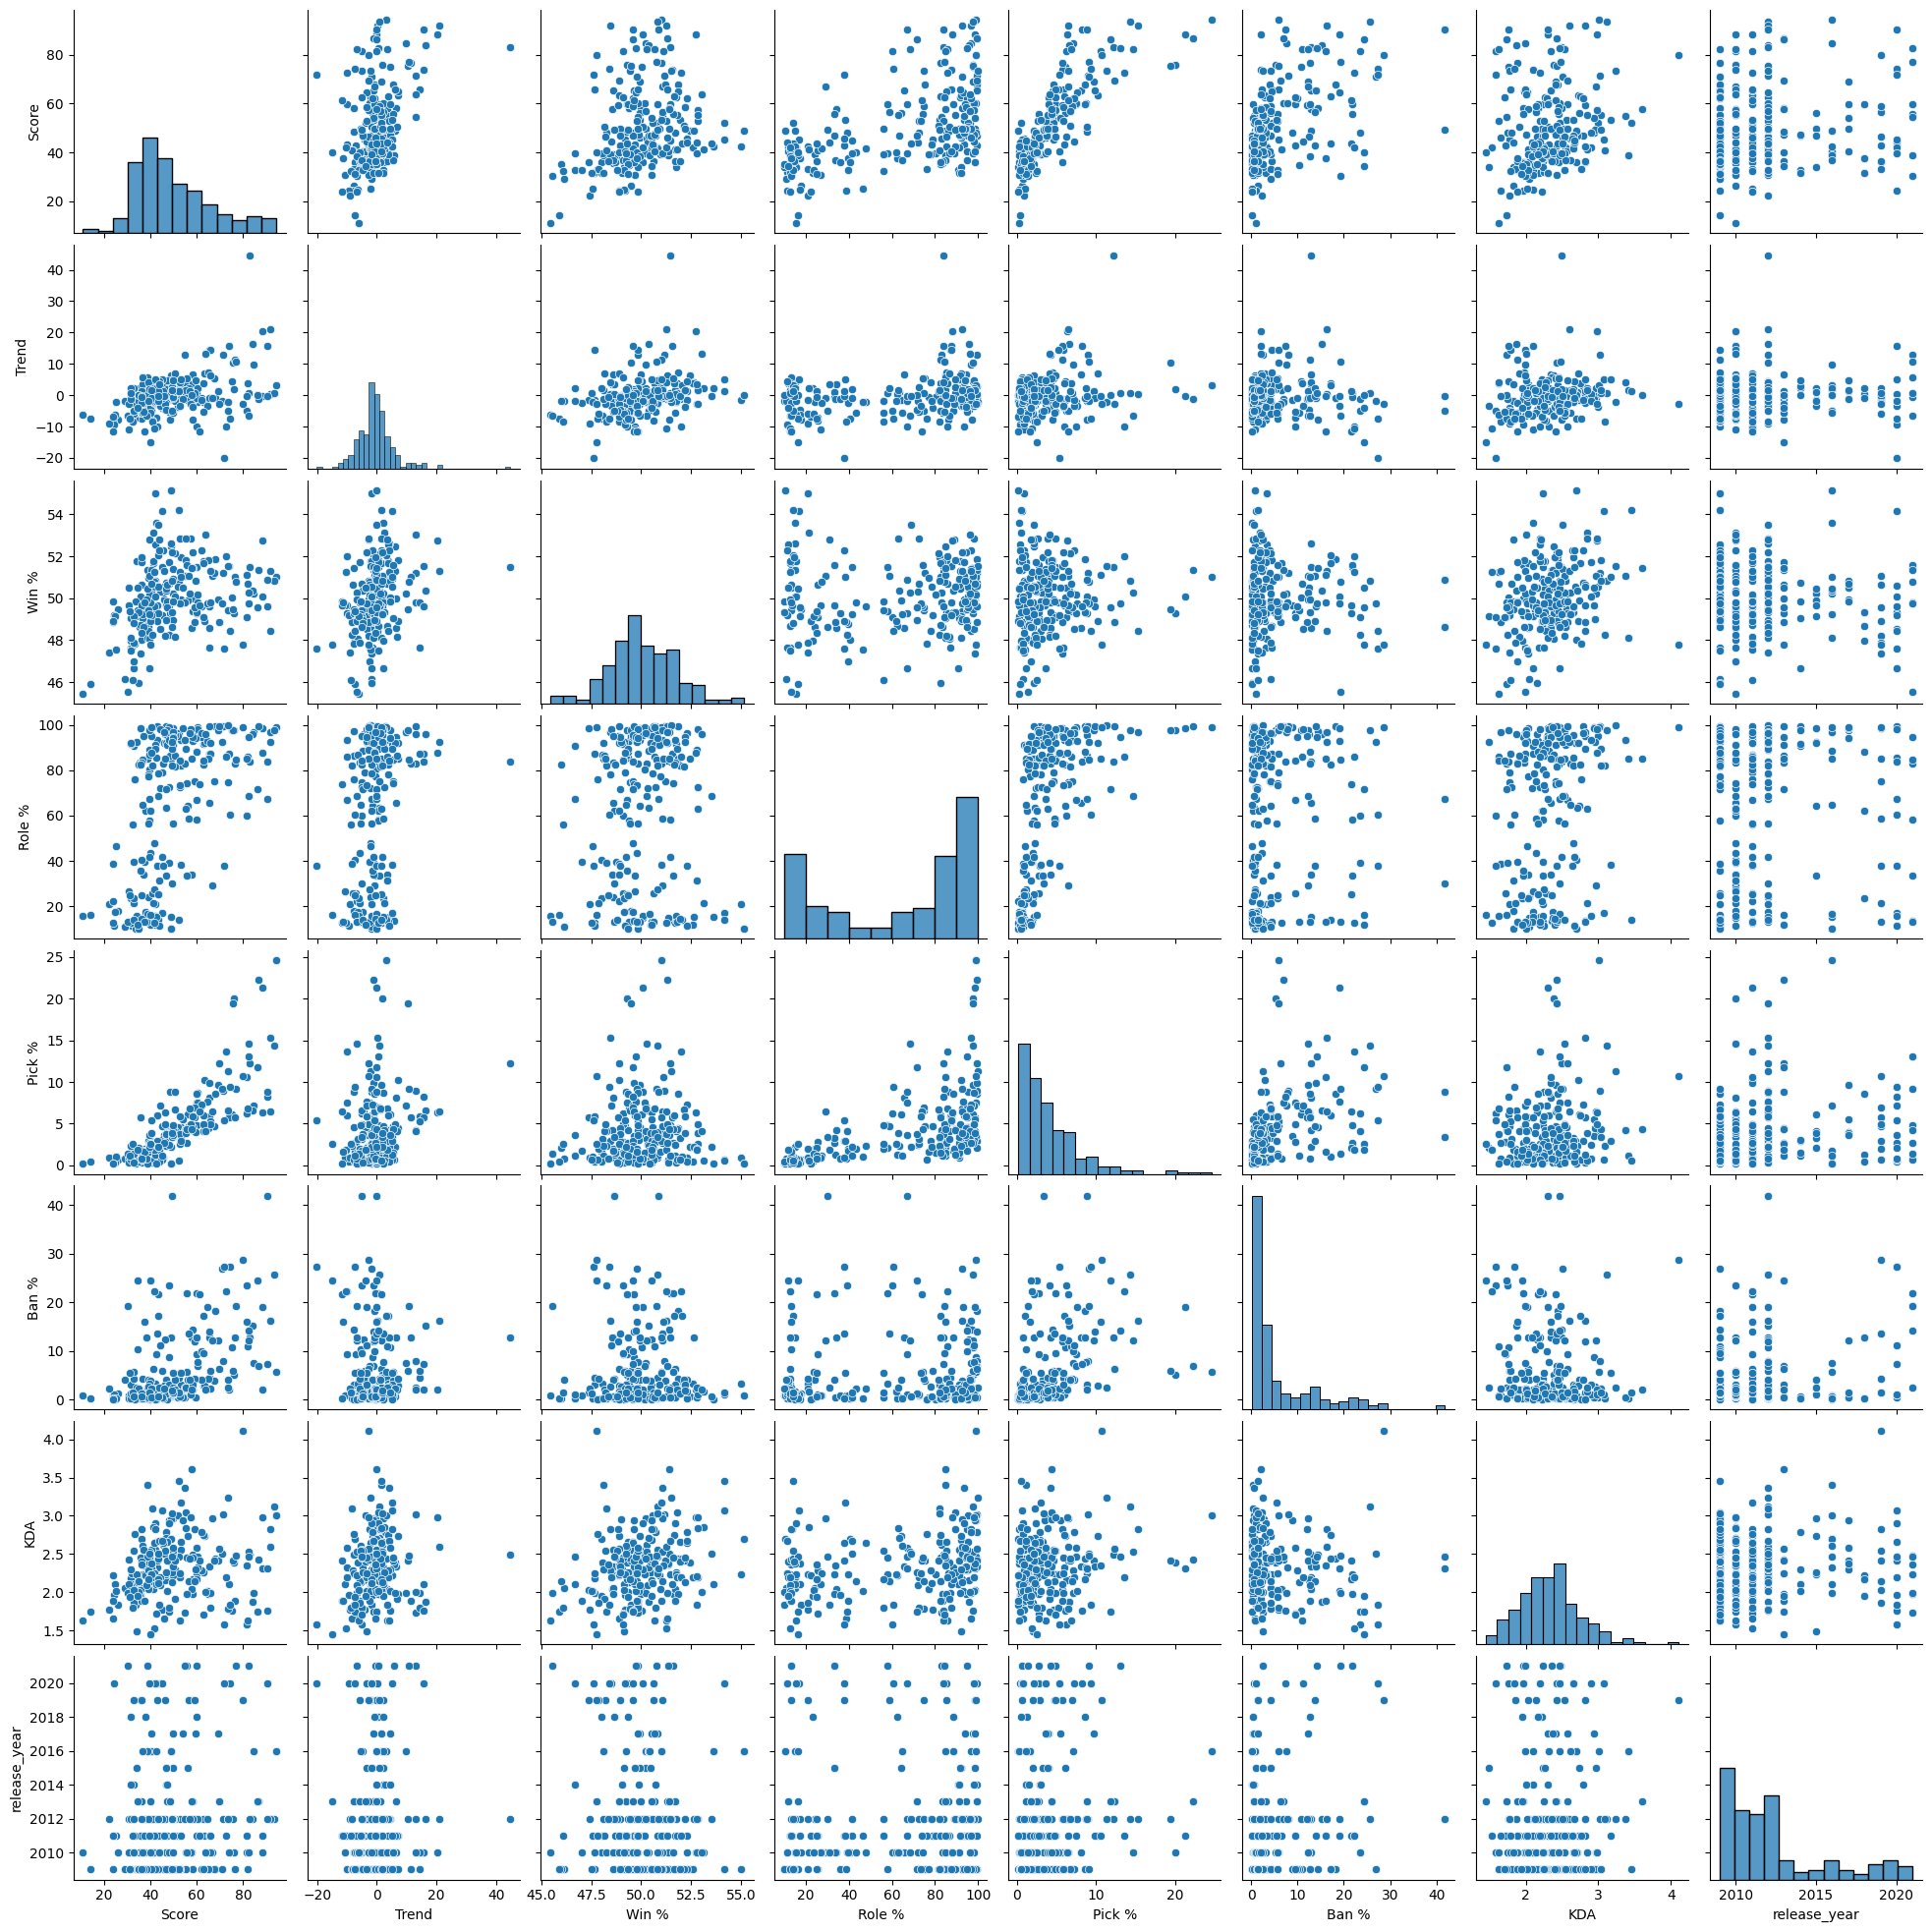

In [23]:
# Pairplot zur Visualisierung der Feature-Zusammenhänge
numerical_features = df.select_dtypes(include=[np.number]).columns
sns.pairplot(df[numerical_features])

C:\Users\maxtr\AppData\Local\Temp\ipykernel_22144\3463312575.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


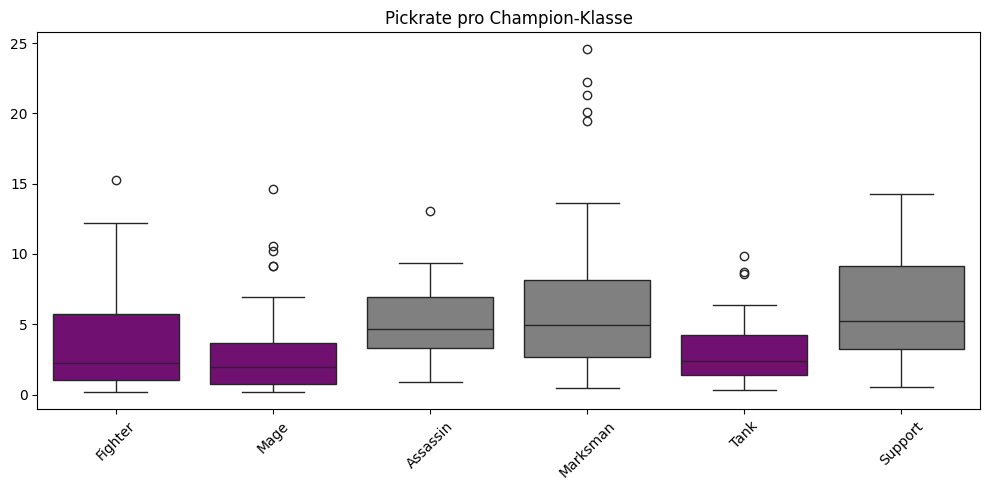

In [24]:
highlight = {"Tank", "Mage", "Fighter"}
purple = "#800080"   

order = ["Fighter", "Mage", "Assassin", "Marksman", "Tank", "Support"]

palette = {c: ("grey" if c not in highlight else purple) for c in order}

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    x="Class",
    y="Pick %",
    data=df,
    order=order,
    palette=palette
)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Pickrate pro Champion-Klasse")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

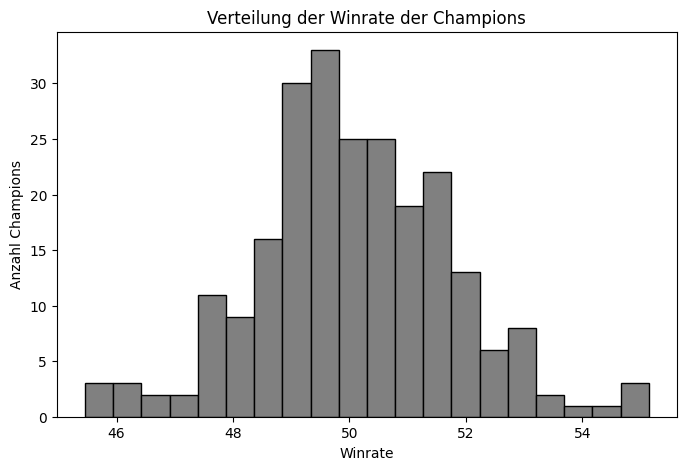

In [25]:
# Histogramm der Winrate

plt.figure(figsize=(8,5))
df['Win %'].hist(bins=20, color='grey', edgecolor='black')
plt.grid(False)
plt.title('Verteilung der Winrate der Champions')
plt.xlabel('Winrate')
plt.ylabel('Anzahl Champions')
plt.show()

### Ydata Profiling Report erstellen

In [26]:
# Bevor die Namensspalte entfernt wird, speichern wir den df in einer neuen Variable
df_name = df.copy()

In [27]:
df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97,94.62,4.43,2.03,1.97,2013.0
1,Ahri,Mage,MID,A,53.21,-0.24,49.93,93.47,4.62,1.04,2.56,2011.0
2,Akali,Assassin,MID,S,65.30,6.51,48.59,65.65,8.16,12.88,2.34,2010.0
3,Akali,Assassin,TOP,A,57.87,3.34,48.57,34.06,4.24,12.88,2.04,2010.0
4,Akshan,Marksman,MID,S,59.85,0.65,51.46,58.01,4.83,21.91,2.23,2021.0


In [28]:
df_name.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97,94.62,4.43,2.03,1.97,2013.0
1,Ahri,Mage,MID,A,53.21,-0.24,49.93,93.47,4.62,1.04,2.56,2011.0
2,Akali,Assassin,MID,S,65.30,6.51,48.59,65.65,8.16,12.88,2.34,2010.0
3,Akali,Assassin,TOP,A,57.87,3.34,48.57,34.06,4.24,12.88,2.04,2010.0
4,Akshan,Marksman,MID,S,59.85,0.65,51.46,58.01,4.83,21.91,2.23,2021.0


In [ ]:
# Für den ydata_profiling Report entfernen wir nicht float Datentypen wie 'Name'
df_profile_report = df.drop(['Name'], axis=1)
df_profile_report = df_profile_report.drop(['Class'], axis=1)
df_profile_report = df_profile_report.drop(['Role'], axis=1)
df_profile_report = df_profile_report.drop(['release_year'], axis=1)
df_profile_report = df_profile_report.drop(['Tier'], axis=1)

# Ydata Profiling Report erstellen
profile = ProfileReport(df_profile_report, explorative=True)

# den Profile Report als HTML-Datei speichern
ytrain = False
if ytrain:
    profile.to_file("ydata_profiling_report.html")

## Modellauswahl

Unser Modell soll vorhersagen, ob und wie Championeigenschaften wie deren Rolle zu einer Unterrepräsentation beitragen. Dazu werden mehrere Machnine Learning Modelle trainiert und anschließend verglichen. Die Modelle sind: Random Forest, Logistic Regression, Support Vector Machine und XGBoost.

### Feature Auswahl und Test-Train-Split

Zuerst wird die Zielvariable (Pick %) von den Features getrennt, und die Daten werden im Verhältnis 80:20 in Trainings- und Testsets aufgeteilt. Zudem wird die Spalte "Name" entfernt, da sie für das Modell nicht einfach in Kategorien oder numerische Werte umgewandelt werden kann. Auch die Variable "Release Year" wird entfernt, da diese keinen logischen Zusammenhang mit der Pickrate hat.

In [30]:
# Die Spalte 'name' wird entfernt
df.drop(columns=["Name"], inplace=True, errors="ignore")

In [31]:
# Zielvariable definieren
X = df.drop(columns=["Pick %"]) 
y = df["Pick %"]

In [32]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X_train.head()

,Class,Role,Tier,Score,Trend,Win %,Role %,Ban %,KDA,release_year
117,Assassin,JUNGLE,B,39.71,-6.54,48.05,86.82,3.24,2.39,2011.0
155,Assassin,JUNGLE,S,62.92,3.87,51.66,82.67,17.16,2.75,2009.0
148,Tank,TOP,D,30.67,-2.66,50.50,13.18,0.34,2.43,2012.0
158,Fighter,JUNGLE,C,35.87,-5.10,48.72,82.59,0.25,2.45,2011.0
231,Support,SUPPORT,A,49.44,1.68,50.83,81.95,1.40,3.03,2009.0


In [34]:
y_train.head()

117    3.12
155    5.98
148    0.32
158    1.49
231    3.38
Name: Pick %, dtype: float64

### Preprocessing 2

Hier kombiniert eine Pipeline das Preprocessing.

In [35]:
# Identifikation numerischer und kategorischer Features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing Pipeline mit OrdinalEncoder (numerische Kodierung von Kategorien)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)  
])


### Modelltestung

Nun werden die Modelle getestet, um zu sehen, welches Modell am besten performt.

In [36]:
# Modelle
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

In [37]:
# Training und Evaluation der Modelle
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {"R² Score": r2, "RMSE": rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}\n")

Training Linear Regression...
Linear Regression: R² = 0.7754, RMSE = 2.0256

Training Random Forest...
Random Forest: R² = 0.9497, RMSE = 0.9589

Training XGBoost...
XGBoost: R² = 0.9646, RMSE = 0.8037

Training Neural Network...
Neural Network: R² = 0.9493, RMSE = 0.9625



c:\Users\maxtr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
# Bestes Modell basierend auf dem höchsten R² Score ermitteln
best_model_name = max(results, key=lambda k: results[k]["R² Score"])
print(f"Bestes Modell: {best_model_name}")

# Bestes Modell aus dem Dictionary holen
best_model = models[best_model_name]


Bestes Modell: XGBoost


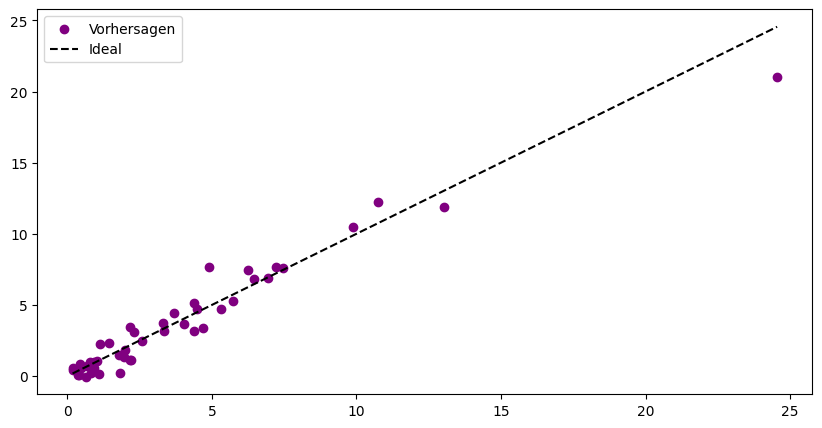

In [39]:
# Visualisierung der Vorhersage
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='purple', label="Vorhersagen")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='black', label="Ideal")
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()


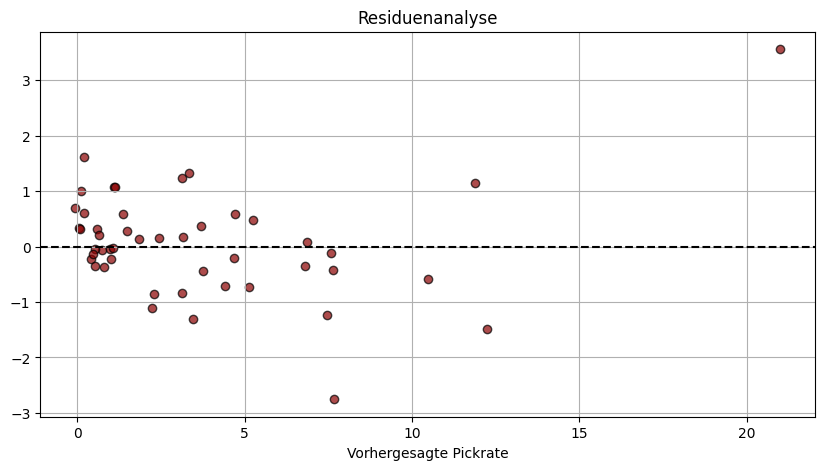

In [40]:
# Residuen berechnen
residuals = y_test - y_pred

# Residuenplot
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.7, color="darkred", edgecolor="black")
plt.axhline(y=0, linestyle='--', color='black')
plt.title("Residuenanalyse")
plt.xlabel("Vorhergesagte Pickrate")
plt.ylabel("")
plt.grid(True)
plt.show()


## Training des Modells


### Hyperparameter-Tuning mit GridSearchCV


In [41]:

# Gitter für die Hyperparameter
param_grids = {
    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 10, 20]
    },
    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__max_depth": [3, 5]
    },
    "Neural Network": {
        "model__hidden_layer_sizes": [(64, 32), (128, 64)],
        "model__alpha": [0.0001, 0.001]
    }
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        print(f"Beste Parameter für {name}: {grid_search.best_params_}")
    else:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        best_model = pipeline
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {"R² Score": r2, "RMSE": rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}\n")


Training Linear Regression...
Linear Regression: R² = 0.7754, RMSE = 2.0256

Training Random Forest...
Beste Parameter für Random Forest: {'model__max_depth': 10, 'model__n_estimators': 100}
Random Forest: R² = 0.9459, RMSE = 0.9943

Training XGBoost...
Beste Parameter für XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
XGBoost: R² = 0.9638, RMSE = 0.8133

Training Neural Network...
Beste Parameter für Neural Network: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (64, 32)}
Neural Network: R² = 0.9465, RMSE = 0.9886



c:\Users\maxtr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [42]:
# Verwende bestes Modell aus GridSearch falls vorhanden
best_xgb = XGBRegressor(
    n_estimators=200,      
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_xgb)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="r2"
)

print("CV R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())
print("Std CV R²:", cv_scores.std())

# 2) Final Fit + Evaluation auf Testset
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Final Test R²: {r2:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")

# Modell speichern
with open("lol_pickrate_model.pkl", "wb") as file:
    pickle.dump(pipeline, file)

CV R² Scores: [0.92868957 0.93413018 0.89188037 0.92260128 0.84178348]
Mean CV R²: 0.9038169763033466
Std CV R²: 0.03429584089327213
Final Test R²: 0.9715
Final Test RMSE: 0.7211


### Feature Importance analysieren

In [43]:
xgb_model = pipeline.named_steps["model"]

# Plotten
importances = xgb_model.feature_importances_

# Feature-Namen aus dem Preprocessor holen
num_names = numeric_features
cat_names = categorical_features

feature_names = num_names + cat_names

xgb_model = pipeline.named_steps["model"]
importances = xgb_model.feature_importances_

for name, score in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")


Role: 0.4900
Score: 0.4275
Role %: 0.0231
Ban %: 0.0204
Win %: 0.0116
Class: 0.0108
Trend: 0.0068
KDA: 0.0050
release_year: 0.0045
Tier: 0.0003


## Championgenerierung / Ergebnisinterpretation

Jetzt wollen wir das beste Modell anwenden, um zu testen, ob es genau ist
Daher nehmen wir die Werte eine Champions der Reihe 1 und testen, ob das Modell 
die Pickrate korrekt vorhersagt
Dazu müssen wir die Werte nicht aus den Trainingsdaten nemhen, sondern aus den ursprünglichen Daten

In [44]:
# Wir bedienen uns der vor langer Zeit erstellten "Backup" - Variable df_name,
# um die Spalte 'Name' wieder hinzuzufügen

df_name.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97,94.62,4.43,2.03,1.97,2013.0
1,Ahri,Mage,MID,A,53.21,-0.24,49.93,93.47,4.62,1.04,2.56,2011.0
2,Akali,Assassin,MID,S,65.30,6.51,48.59,65.65,8.16,12.88,2.34,2010.0
3,Akali,Assassin,TOP,A,57.87,3.34,48.57,34.06,4.24,12.88,2.04,2010.0
4,Akshan,Marksman,MID,S,59.85,0.65,51.46,58.01,4.83,21.91,2.23,2021.0


In [45]:
# die echten Werte des Champions "Aatrox' anzeigen
champion = df_name[df_name['Name'] == 'Aatrox'].iloc[0].to_dict()
champion

{'Name': 'Aatrox',
 'Class': 'Fighter',
 'Role': 'TOP',
 'Tier': 'A',
 'Score': 58.25,
 'Trend': 6.52,
 'Win %': 49.97,
 'Role %': 94.62,
 'Pick %': 4.43,
 'Ban %': 2.03,
 'KDA': 1.97,
 'release_year': 2013.0}

In [46]:
# Pickrate vorhersagen
with open("lol_pickrate_model.pkl", "rb") as file:
    model = pickle.load(file)

In [47]:
# Werte des Champions in ein DataFrame umwandeln
champion_df = pd.DataFrame([champion])

# Namensspalte rausnehmen
champion_df = champion_df.drop(columns=["Name"], errors="ignore")
                               
# Pickrate vorhersagen
pickrate = model.predict(champion_df)[0]
print(f"Vorhergesagte Pickrate für Aatrox: {pickrate:.4f}%")

Vorhergesagte Pickrate für Aatrox: 4.4209%


In [48]:
# Werte des Champions "Xerath' betrachten
champion = df_name[df_name['Name'] == 'Xerath'].iloc[0].to_dict()
champion

{'Name': 'Xerath',
 'Class': 'Mage',
 'Role': 'MID',
 'Tier': 'A',
 'Score': 53.25,
 'Trend': 5.16,
 'Win %': 51.01,
 'Role %': 38.11,
 'Pick %': 2.97,
 'Ban %': 5.53,
 'KDA': 3.17,
 'release_year': 2011.0}

In [49]:
champion = df_name[df_name['Name'] == 'Xerath'].iloc[0].to_dict()
champion_df = pd.DataFrame([champion])
champion_df = champion_df.drop(columns=["Name"], errors="ignore")
pickrate = pipeline.predict(champion_df)[0]
print(f"Vorhergesagte Pickrate für Xerath: {pickrate:.4f}%")

Vorhergesagte Pickrate für Xerath: 2.9699%


Die Pickrates wurden super vorhergesagt! :D

In [50]:
# Champion mit niedrigster Pickrate als Vergleich anzeigen
champion_underrep = df_name.loc[df_name["Pick %"].idxmin()]
print("Champion mit den am niedrigsten Pickrate:")
print(champion_underrep)

Champion mit den am niedrigsten Pickrate:
Name            Skarner
Class           Fighter
Role                TOP
Tier                  D
Score             23.89
Trend             -6.83
Win %              48.9
Role %            22.21
Pick %             0.18
Ban %              0.16
KDA                2.22
release_year     2011.0
Name: 164, dtype: object


Jetzt werden durchschnittliche Werte für alle Variablen außer Class und Role genommen, um diese kategorialen Variablen vorherzusagen. Es soll nämlich erkannt werden, welche Klasse und Rolle bei durchschnittlichen Werten am unterrepräsentiertesten ist. 

In [51]:
# Modell laden
with open("lol_pickrate_model.pkl", "rb") as file:
    model = pickle.load(file)

In [52]:
# Definieren kategorialer Features
variable_features = ['Class', 'Role']

In [53]:
# Erstellen aller möglichen Kombinationen aus Class und Role
combinations = list(product(
    df['Class'].dropna().unique(),
    df['Role'].dropna().unique()
))

In [54]:
# Setzen aller anderen Features auf den Mittelwert
fixed_values = {}

for col in df.columns:
    if col not in variable_features + ['Name', 'Pick %']:
        if pd.api.types.is_numeric_dtype(df[col]):
            fixed_values[col] = df[col].mean()
        else:
            fixed_values[col] = df[col].mode()[0] 

In [55]:
# Iterieren durch alle Kombinationen der kategorialen Werte
min_pred = float('inf')
best_candidate = None

for class_val, role_val in combinations:
    candidate = fixed_values.copy()
    candidate['Class'] = class_val
    candidate['Role'] = role_val

    candidate_df = pd.DataFrame([candidate])
    pred = model.predict(candidate_df)[0]

    if pred < min_pred:
        min_pred = pred
        best_candidate = candidate

print("Theoretische Champion-Komposition (bei durchschnittlicher Leistung):")
print(best_candidate)
print("Vorhergesagte Pickrate: {:.2f}%".format(min_pred))

Theoretische Champion-Komposition (bei durchschnittlicher Leistung):
{'Tier': 'A', 'Score': 49.95367521367521, 'Trend': -0.2829914529914531, 'Win %': 50.05893162393163, 'Role %': 64.01623931623931, 'Ban %': 5.824145299145298, 'KDA': 2.3328632478632483, 'release_year': 2012.1495726495727, 'Class': 'Fighter', 'Role': 'TOP'}
Vorhergesagte Pickrate: 4.23%


## Ergebnisinterpretation

Die Analyse zeigt, dass die Rolle "Top" und die Klasse "Tank" (Class Tank) bei durschnittlichen Werten unterrepräsentierte Champions ausmacht. Besonders die Klasse lässt sich logisch nachvollziehen, beispielsweise wurden Champions der Klasse "Tank", in den letzten Jahren oft gar nicht oder selten pro Jahr veröffentlicht. Weiters wird auf diese Thematik in der schriftlichen Arbeit genauer eingegangen.